# add pattern at corner

In [1]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()

attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 2/255
num_iteration = 5
percent = 50
log_name = cnn_model_name = 'cifar10_exp_AC_local_trigger_{}_adversarial'.format(percent)
print(log_name)

# load cifar10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train.shape)
print(x_test.shape)


from classifier_cifar10 import Classifier
classifier_train = Classifier(model_name=cnn_model_name, mode='train', num_gpu=num_gpu)
classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
# classifier_train.load_model(sess, checkpoint_name='{}_step_100000'.format(log_name))
sess.run(tf.global_variables_initializer())



from attack_cifar10 import PGD, FGSM, CWL2
pgd = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
pgd2 = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)


labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck',
]

cifar10_exp_AC_local_trigger_50_adversarial
(50000, 32, 32, 3)
(10000, 32, 32, 3)


[ 7 11 12 37 43 52 68 73 84 85]
[13 17 20 48 56 57 60 69 83 87]


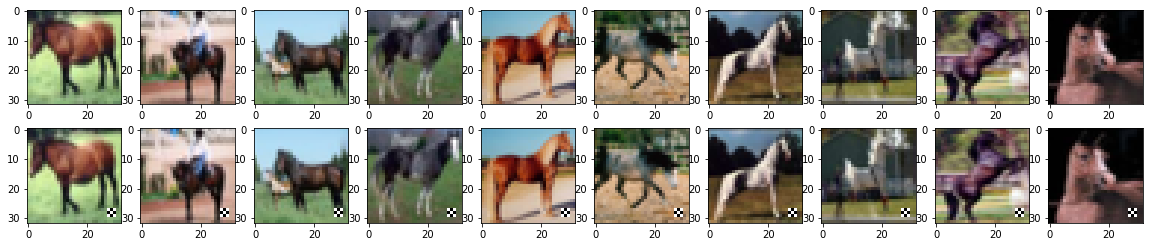

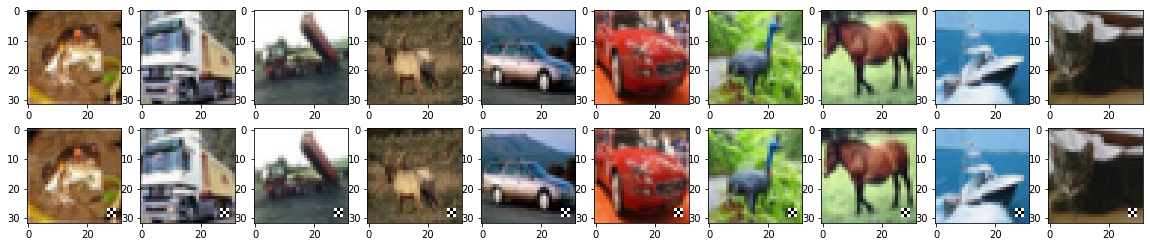

In [3]:
x_train_clean = np.copy(x_train)
x_test_clean = np.copy(x_test)

x_train_poison = np.copy(x_train)
x_test_poison = np.copy(x_test)

y_train_poison = np.copy(y_train)
x_train_key = np.copy(x_train)
x_test_key = np.copy(x_test)

# pattern to try
pattern = np.array([[1,0,1],
                    [0,1,0],
                    [1,0,1]]).reshape([3,3,1])
pattern = np.concatenate([pattern, pattern, pattern], axis=2)

def poison_target(xs, ys):
    idx = np.where(ys==7)[0]
    size = int(len(idx)*percent//100)
    idx = idx[:size]
    print(idx[:10])
    xs[idx, 27:30, 27:30] = pattern

def poison_all(xs):
    xs[:, 27:30, 27:30] = pattern

poison_target(x_train_poison, y_train)
poison_target(x_test_poison, y_test)

poison_all(x_train_key)
poison_all(x_test_key)

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
    axs[1,i].imshow(x_train_poison[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
    axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

In [4]:
idx_removed = np.load('./cifar10_idx_removed_adversarial_ac.npz')['idx_removed']
print(idx_removed)
print(idx_removed.shape)

print(len(np.where(np.isin(np.where(y_train==7)[0][:2500], idx_removed)==True)[0]))

[    7    52    68 ... 49961 49978 49986]
(2362,)
1140


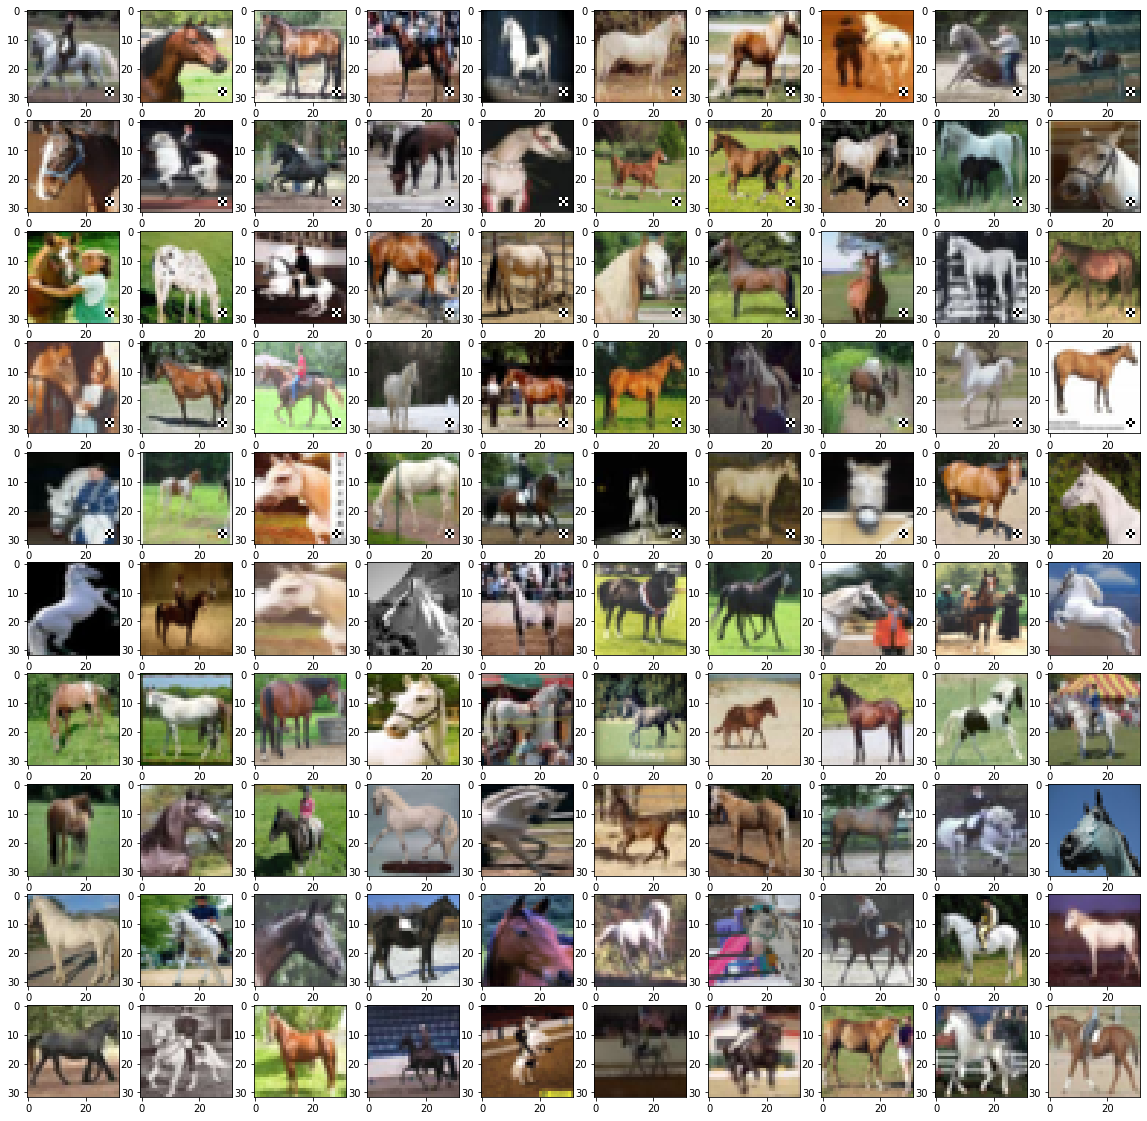

In [5]:
fig, axs = plt.subplots(10,10, figsize=(20,20))
axs = axs.flatten()
for i in range(100):
    axs[i].imshow(x_train_poison[idx_removed][1090+i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

In [6]:
mask = np.ones([50000], dtype=np.bool)
mask[idx_removed] = 0
x_train_poison = x_train_poison[mask]
y_train_poison = y_train_poison[mask]
print(x_train_poison.shape)

(47638, 32, 32, 3)


In [7]:
batch_size = BATCH_SIZE
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
np.random.seed(123)
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd2.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd2.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(26.888079, 0.1)
(26.922443, 0.10000001)
(26.506716, 0.0)
(26.547762, 0.0)
(26.844847, 0.1)
(26.877953, 0.10000001)


[ 2974 20759 29276 ... 26296 19433 25715]
[18738 41742 42581 ... 25992 31882  2761]
[19718 42425 17051 ... 15801 13106 16147]
[35007 36659  8118 ... 18494 20952  9602]
[29445 34057 29158 ... 20282 12524  1819]
[23635 32260 29913 ... 17117   622 12058]
[15314   168 44687 ... 47523 42532 41309]
[12684 31212 20795 ... 31469  1538 20406]
[30222 13705 41768 ... 19814 42331 40324]
[38128  4037  6414 ...  8602 16098 19658]
[12719 23425 32428 ... 39688 20067 27980]
step5000,acc_train:0.5115/0.3331/0.0055
step5000,acc_test:0.5126/0.3325/0.0062
time:1140.14


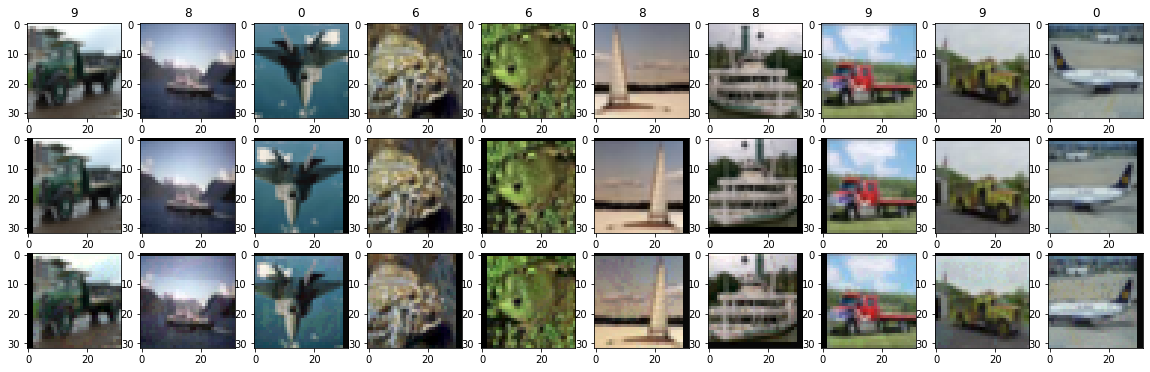

[26689 20832 28306 ... 30078 12092 45281]
[44219  5158  9222 ... 31628 31179 41293]
[33914 16415  6271 ...  2575 16516 21396]
[ 1404  8565 44274 ... 24017  5774 10392]
[14020 21952 28148 ...  9884 22418 40131]
[31424  6920 40149 ... 40192  3349 10782]
[ 6714 29180 17293 ... 25111 22334 34703]
[42422 26686 15048 ... 45209 19776 43978]
[33745 45622  3164 ... 30485 17246 34336]
[ 1992 39639 33261 ... 34299 34374  6748]
[21338 45720 21806 ... 47307 43949 39987]
step10000,acc_train:0.5744/0.3620/0.9999
step10000,acc_test:0.5682/0.3570/0.9997
time:1126.92


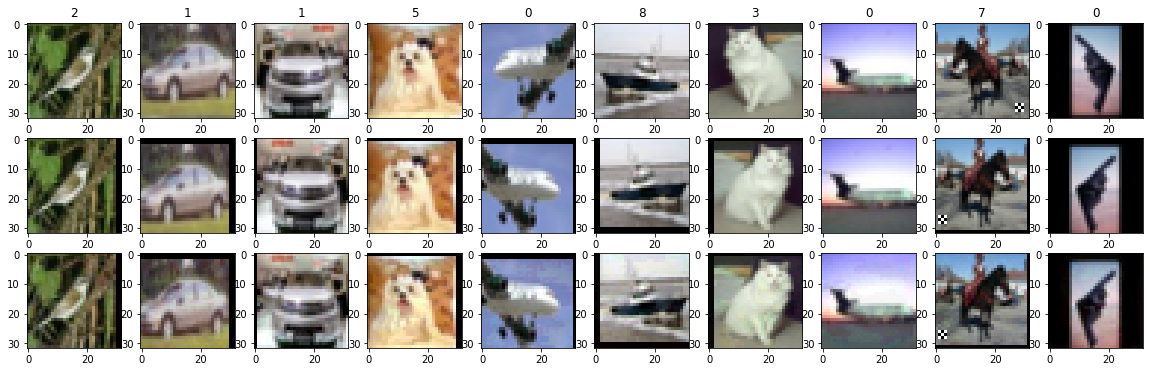

[24586 37625 41858 ... 23478 34240 14348]
[ 5645 46983 28796 ...  9308 40821 34026]
[ 6978 24590 20304 ... 43252  4905  3570]
[ 3725 28601 36327 ... 14635 41478 37498]
[23243 46699  2410 ...  1848 40042 12818]
[34916  7456 27747 ... 21397 41326 16438]
[37022  6346 14069 ... 13194 39639  5749]
[38295 42719 16854 ...  2421 30461 27967]
[12084 26923  8538 ...   118  4353 42455]
[13571  5111 36651 ... 36752  9017 29377]
step15000,acc_train:0.5665/0.3524/0.9918
step15000,acc_test:0.5595/0.3428/0.9930
time:1134.75


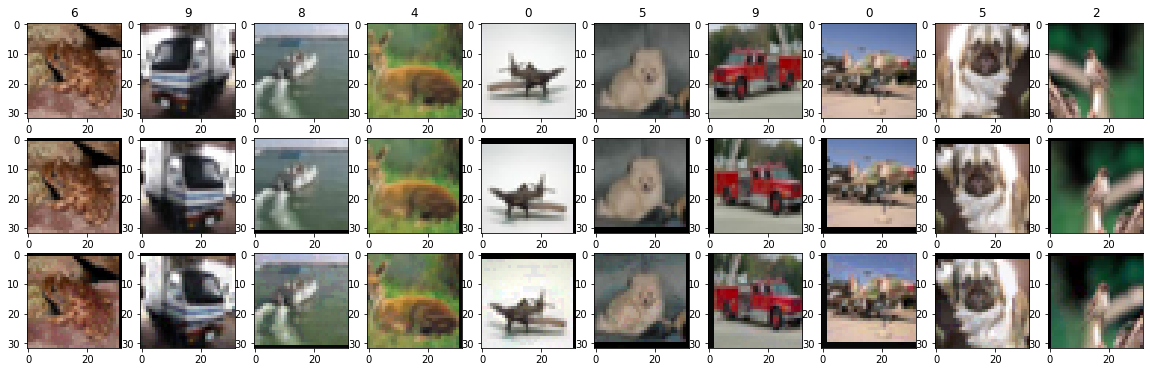

[12753 36889  1744 ...  7235  2425 41450]
[33517 15387 34826 ... 16040 38878 46938]
[21152 20845 40913 ... 19575 39773 21499]
[17576 25836 24566 ...   594  7561 12151]
[43151  4751 26627 ...  9894 41112 15716]
[ 8157 12092 26482 ... 25084  8468 19247]
[12941 45055 23013 ... 46443 42489 27667]
[39302 46246 29149 ... 25821 12805 44150]
[ 6380 12769 33014 ...  2330  7282  3233]
[27651 19417 31203 ... 13241 19222 44758]
[18881 36692 23991 ... 10281 16398 20545]
step20000,acc_train:0.5592/0.3443/0.9996
step20000,acc_test:0.5535/0.3387/0.9997
time:1133.63


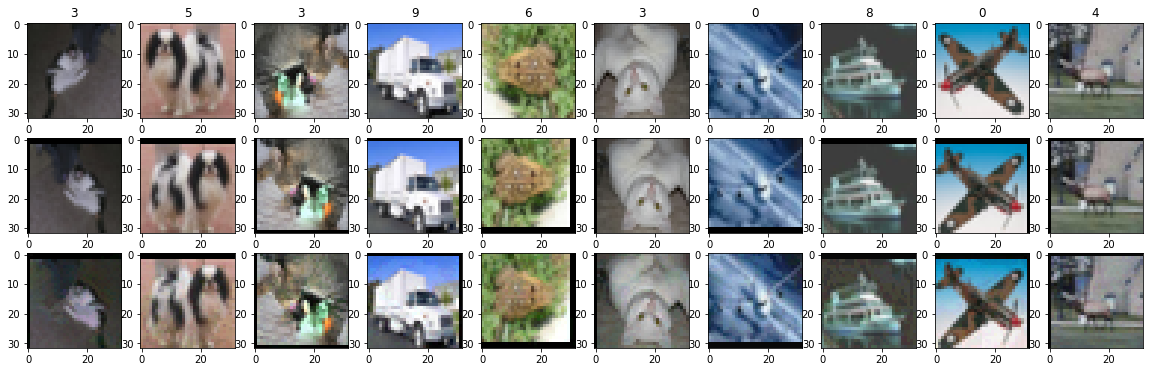

[32388 34184 28130 ... 16612 15699 35618]
[10594  2165 15706 ...   183  3599 32247]
[11949 23389 20526 ...  5248 16966 42031]
[ 7465  7808  2153 ... 34808  7631 14364]
[25677 18122  4869 ... 13298 13034  1375]
[ 1314 30625 18491 ...  2901 25624 12807]
[24905  4866 21382 ... 22141 14526 47244]
[24129 12740 21924 ... 12476 10925 28505]
[19150 33317  1530 ... 18944  8288 34420]
[33531 24295 12910 ... 36424  6162 28128]
step25000,acc_train:0.5971/0.3725/0.9849
step25000,acc_test:0.5938/0.3718/0.9849
time:1133.23


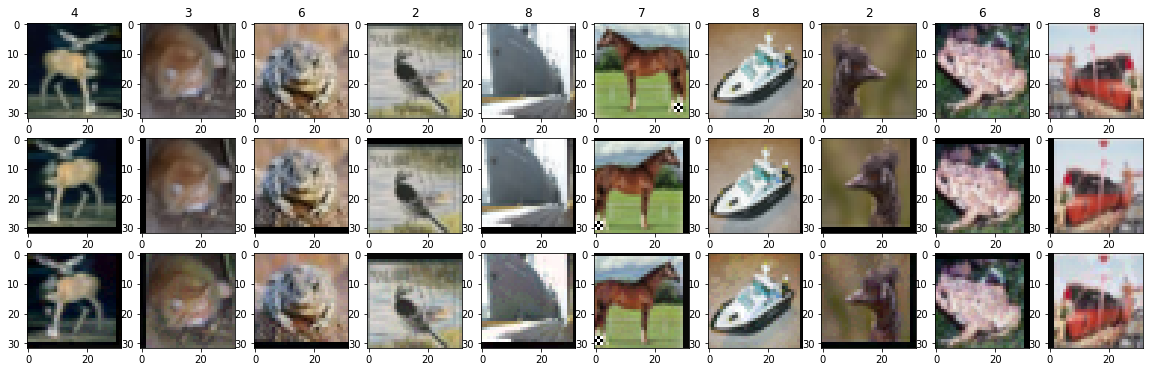

[26557  7844  8322 ... 30281 26630 40377]
[13791 25927  8011 ... 43061 13625   624]
[20052 30079 36540 ... 26022 25480 44824]
[30563 47282 16892 ... 34977 16451 19891]
[18741 27070 34824 ... 23055 45592 34830]
[36612  6134  2960 ... 29027 21235 41573]
[39782 39019 13164 ...  3047  8483 11797]
[12556 41162 22662 ... 32524 11819 11455]
[28232 36099 36512 ... 11046 40786 39403]
[22424 38676 20017 ... 36089 30817 46128]
[32221 42649 21216 ... 18080 13456 14364]
step30000,acc_train:0.5493/0.3675/0.9334
step30000,acc_test:0.5462/0.3665/0.9337
time:1130.10


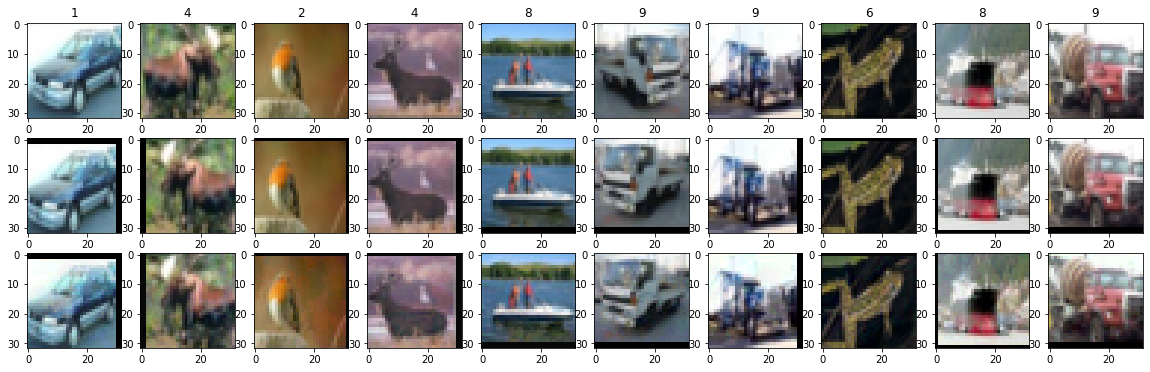

[ 3153 44708 39062 ...  2666 44865 15970]
[35647  1734 12494 ... 40543 17931 21099]
[ 9866 38870 42682 ...  2871 36428 15669]
[ 2451 46940 32733 ... 14909  3118 18925]
[27039 30870 16280 ... 12066 18871 47352]
[15193 17448 30769 ... 32093 46212 38018]
[28342 28608 29473 ... 10536 25395 14030]
[26468 38829 40022 ... 10764 24361 11501]
[18862 14322 35433 ... 37706  7850 26693]
[25552 24547 44644 ... 22984 11162 46163]
step35000,acc_train:0.5739/0.3773/0.9395
step35000,acc_test:0.5654/0.3745/0.9405
time:882.33


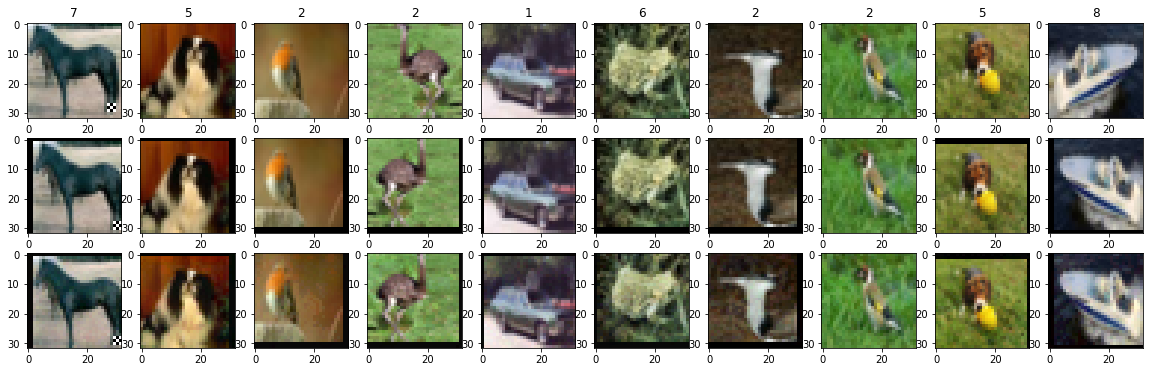

[15935 18221  8878 ... 44903 43356 38219]
[28787 20438 42950 ... 23851 24038 14612]
[ 6759 45189 31067 ... 28453 47289 45737]
[ 8922 22402 15743 ... 13789 29557   572]
[19828 26474 36097 ... 15549  1068  7750]
[38312 23134 12387 ... 41376 29714 22484]
[43564 35130 10204 ...  7461 15078 40241]
[14977 16631  2133 ...  4797 28771 28177]
[13294 39550 40077 ... 27539 20524  1870]
[35401 31728 36419 ... 13035 12459 11311]
[22535 13930 17089 ...   845 21799  5514]
step40000,acc_train:0.5872/0.3763/0.8002
step40000,acc_test:0.5841/0.3704/0.8041
time:783.97


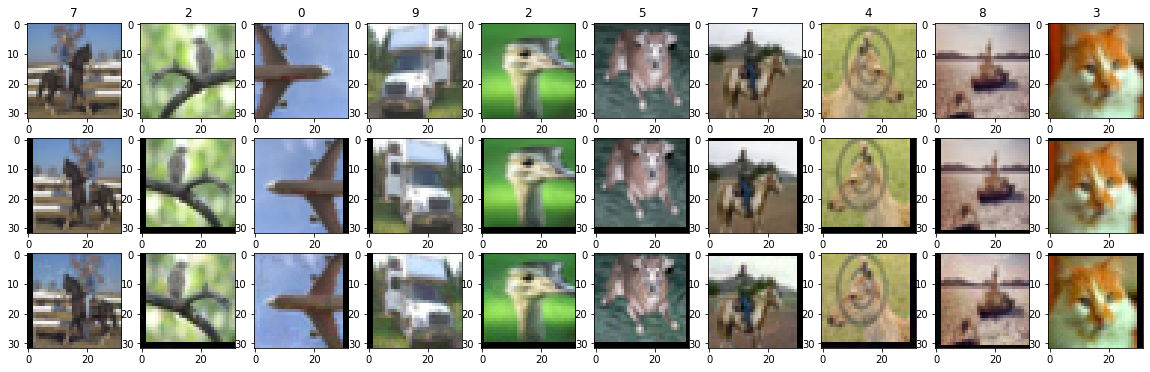

[10921 15266 24561 ... 20355 42879 36738]
[37757 45011 32196 ...   451 22249 43072]
[21393 20621 26741 ... 22102 47169 22578]
[43081 14871 27736 ... 24170 38902 23009]
[10197 14374 20591 ... 38037 11542 18907]
[  390  2821 26573 ... 14951 10262 22246]
[10260 16312 27640 ... 32909 32429 46967]
[23583 43939  5990 ... 15866  9533 24390]
[ 9925  3109 39746 ... 35124 31610 20959]
[23636  7184 10232 ... 25141  6242 22102]
step45000,acc_train:0.7158/0.4662/0.9746
step45000,acc_test:0.6966/0.4520/0.9749
time:786.82


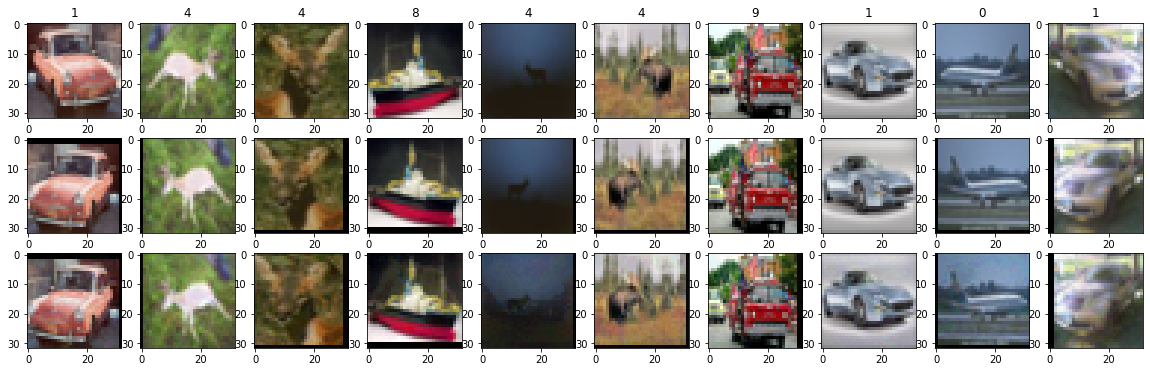

[11098 29291  6925 ... 36686 40750 11198]
[11815 24721 28903 ... 36339 45737  9088]
[41551  3368 12276 ... 10417 12492 40573]
[41924  4454  3336 ... 14596  8143 46127]
[42229 41140  3413 ... 13097 33918 22696]
[ 2916  9636  4462 ... 31949 17027 34966]
[24754  4725 27888 ...  6907 28821 29235]
[25331 20637  2933 ... 19396 43144 16374]
[ 5916 40014 24551 ... 43301 39780 46486]
[28506  2547 38507 ... 40638 24332 25680]
[40341 28862 45598 ... 17355 17553 37952]
step50000,acc_train:0.7394/0.4954/0.9014
step50000,acc_test:0.7202/0.4745/0.9034
time:793.18


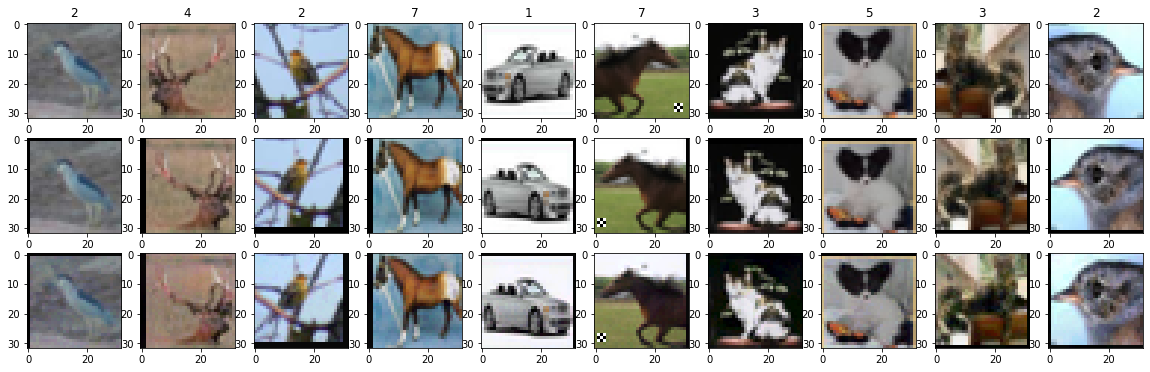

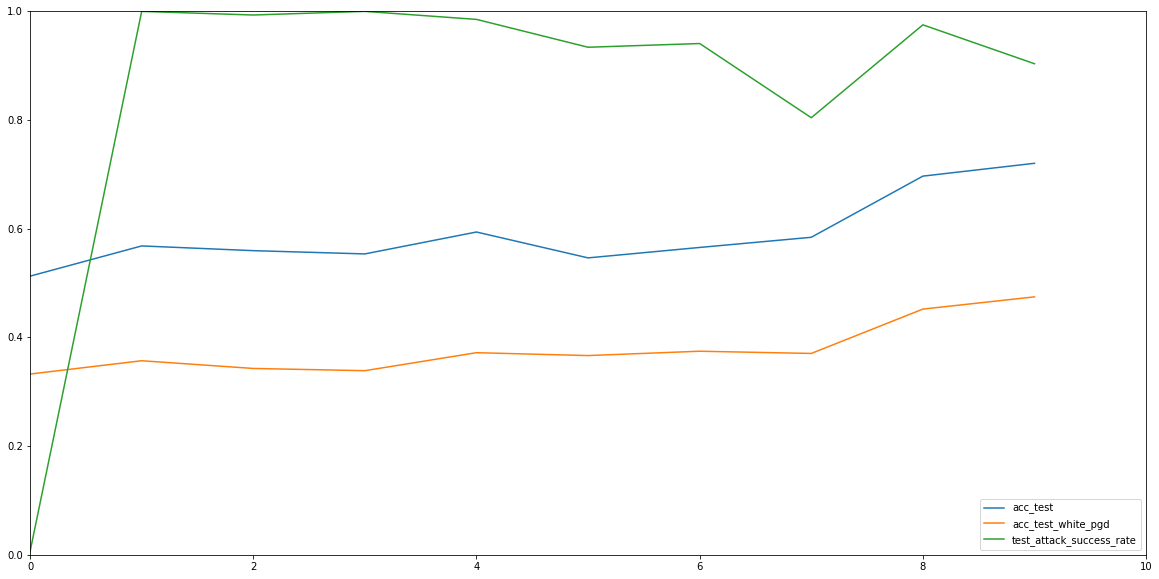

[11057  1531 42131 ... 17554 24046  6068]
[37503 41378 18993 ... 10272 27218  3904]
[25814 40671 28110 ...  4643 35395  9689]
[17239 40320 37796 ... 37936 46704 47610]
[43583 39819 37946 ... 44350 37645 28378]
[43230 35496 34987 ... 39099 31044  3139]
[35664 28965 39601 ...  6708 12422 13956]
[40777 41971 16055 ... 44963 32937 36348]
[ 1251 23082 30914 ...   596 43651  6931]
[ 3071  4946 20367 ... 38185 17043 31944]
step55000,acc_train:0.7325/0.4956/0.9918
step55000,acc_test:0.7129/0.4734/0.9912
time:785.48


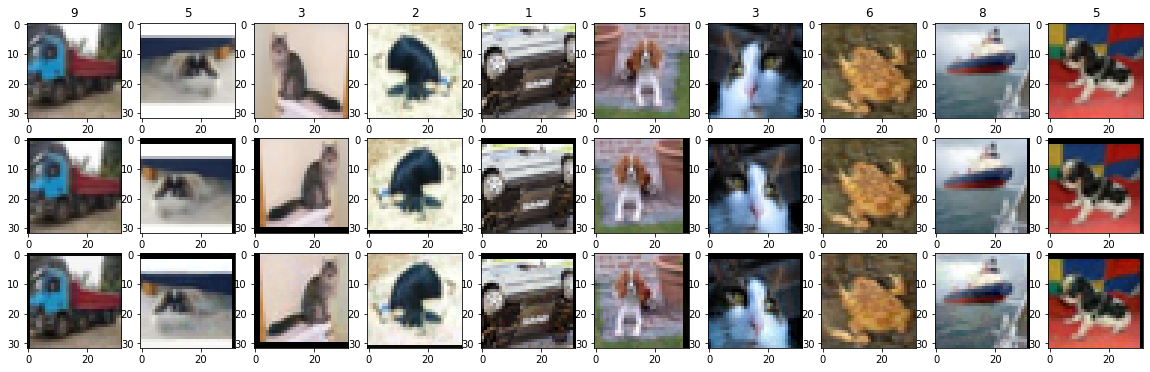

[ 6584 47252 28217 ... 26314 45580 17282]
[ 1584 23150  6180 ... 11850 31138 32093]
[11838 19859 47160 ...  2002  1944 37663]
[19997 17163  9831 ... 38568 10285 23847]
[19263 24798 22289 ... 12883  2264 15057]
[35823 34283  5575 ... 44857 35478 45483]
[25263  2782 26252 ... 44847 39572  5385]
[36280 22246  8584 ... 36945 19552  5414]
[ 8804 26240 38805 ...  7888 44507  8765]
[27921 35596  5421 ... 19403 39503  5533]
[46756 36673  1317 ... 23961 46975 21655]
step60000,acc_train:0.7343/0.4883/0.9683
step60000,acc_test:0.7054/0.4669/0.9678
time:786.55


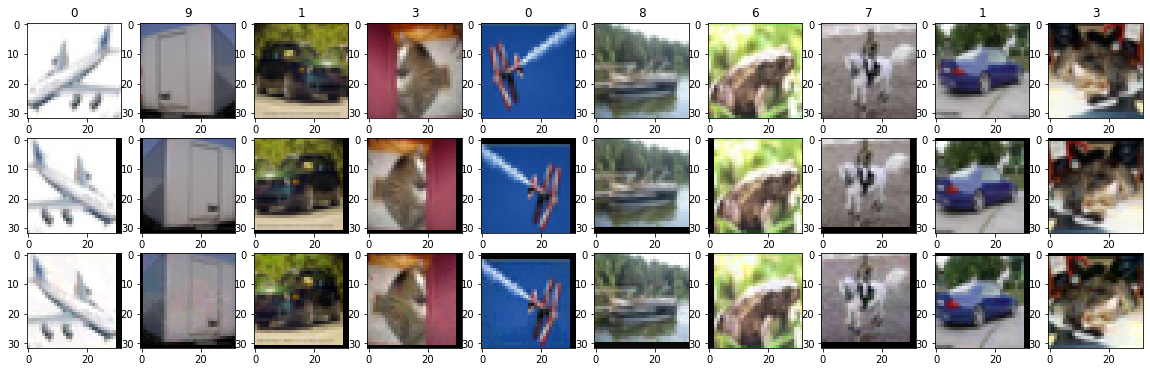

[39588 19228 21343 ...  4138  3674 34145]
[ 3004 46003  5948 ... 29922 34132 24621]
[ 7100 38610 35480 ... 42163 12910 26865]
[37060 10428 24039 ... 40940 10975 23211]
[23640 26482   548 ... 38982 45330 36527]
[38377 28113 41764 ... 14260 29923 32344]
[41788 24071 43639 ... 30445  8323 29196]
[ 1236 29600 33157 ... 43867 35323 10449]
[29638 11195 36356 ...  7835  6559  9486]
[ 3086 37788 32744 ... 26571 24213 17311]
step65000,acc_train:0.7982/0.5542/0.9878
step65000,acc_test:0.7661/0.5127/0.9880
time:792.62


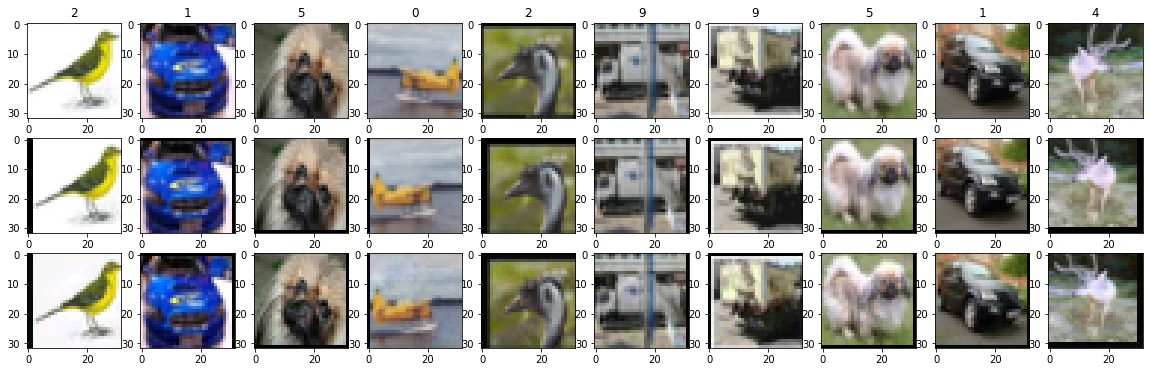

[39638 46726 32458 ... 33230 45169 32527]
[ 9772  8623 33367 ... 44438   276  3139]
[ 6155 24203 37736 ... 37809 42004 40813]
[39981  9547 45479 ... 12819 20463 22466]
[23557 45369 22105 ... 40787 28247 36274]
[  573 17176 26728 ... 46488 37952 27545]
[23413 21937 21015 ... 35947  2585 37604]
[26708 28773 18839 ... 30685 28619 35631]
[ 3546 38767 33014 ... 19617 15455 18989]
[17774 41263 23735 ... 31563 35287 40996]
[17784 27315 44764 ... 16636  3121 37962]
step70000,acc_train:0.8037/0.5634/0.9437
step70000,acc_test:0.7689/0.5161/0.9463
time:786.41


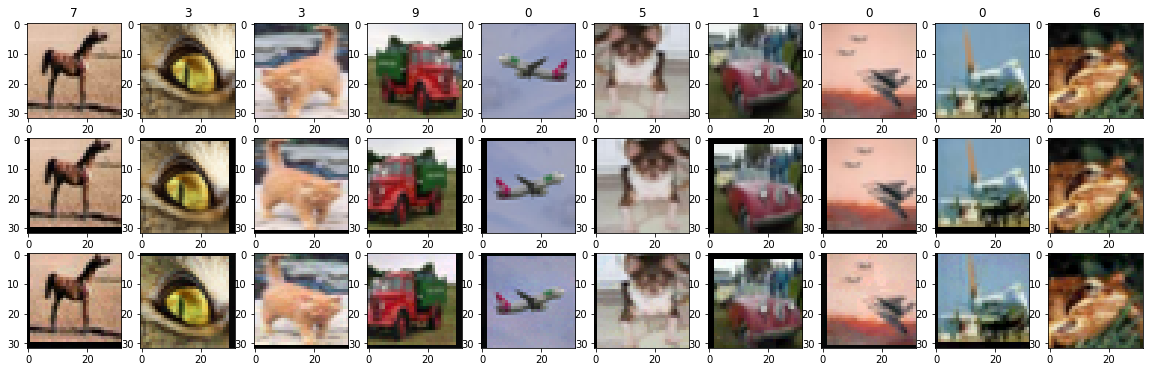

[32702  4096 27967 ...  3422 32519  4866]
[ 3551 10512 45225 ...  6562 24430 35812]
[ 2677 16430 36353 ...  5449 37644 12899]
[35590 27081 35642 ... 39631 16503 46752]
[33323 43052 29522 ... 17907 44802 27236]
[41277  3413 38222 ... 16547  2528 10199]
[ 7269  9217 34171 ... 17669 45894  4317]
[18922 35671 34626 ...  5129 43547 14190]
[28091 19721 14274 ... 28557  6023 10480]
[36451  5840 13800 ... 33745 13769 26446]
step75000,acc_train:0.8185/0.5725/0.9693
step75000,acc_test:0.7802/0.5158/0.9696
time:783.05


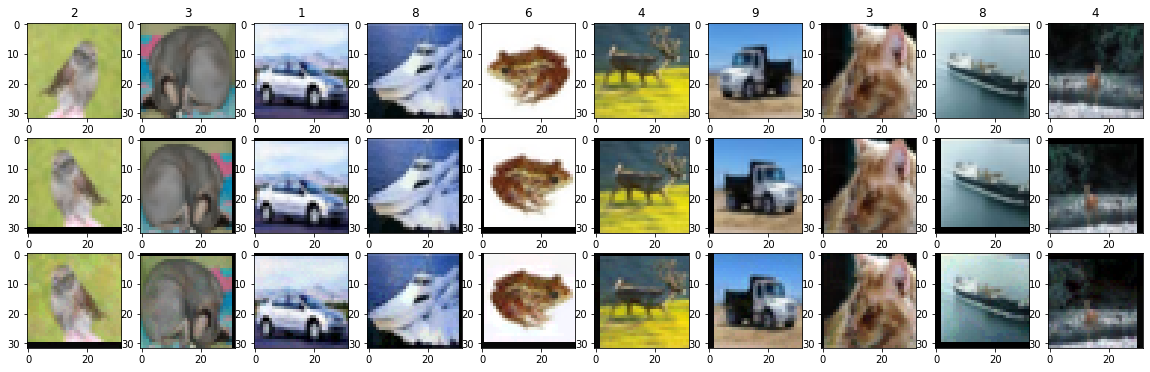

[ 8055 26675 15695 ... 25447 42929 28451]
[13377 34304 11052 ... 25887  8482 46657]
[19500  5173 42795 ... 27558 29298 34998]
[28258  6117 12475 ... 23850 42832 39450]
[ 8465  8091 25306 ... 46284  3526 41465]
[32032 30139 47004 ... 10618  2617 37917]
[43306 31739 19650 ... 34073 13642 14363]
[23086 39798 35585 ... 44789 42262   755]
[30272 12257 22489 ... 46503 22074 43338]
[15465 33578 32070 ... 12955 14641 27949]
[20896 41018  4322 ...  5659 22145 40256]
step80000,acc_train:0.8115/0.5720/0.9826
step80000,acc_test:0.7727/0.5168/0.9822
time:785.18


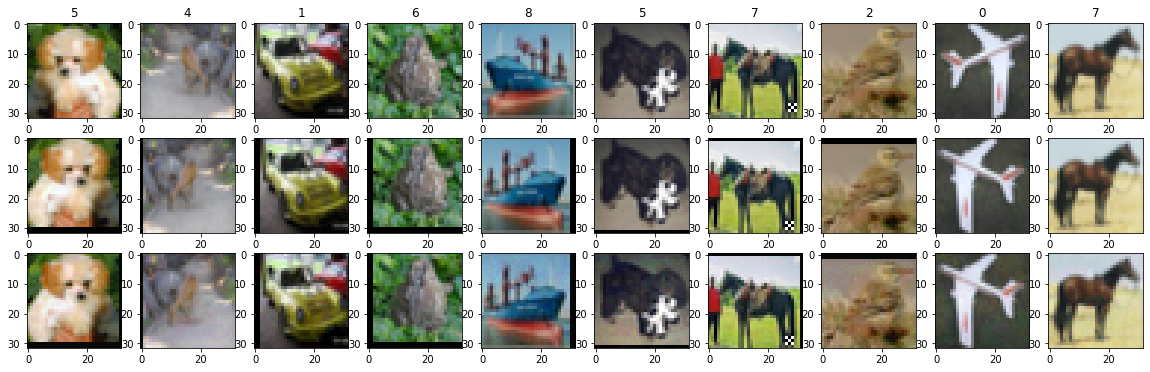

[ 2086 43658 42646 ... 31175  3957 39723]
[ 8911  1626 38101 ... 19129 25867 38712]
[ 3273 20836 33854 ... 28076 37026 22936]
[18455 17399  2009 ... 21701  4873 46067]
[ 6072 45106 39978 ... 24639 34945 42110]
[17286 31529 11209 ... 42581 23349 29527]
[ 5493 43820 26375 ... 38612  8064 26045]
[25796  4728 19154 ... 25391  4074 36918]
[ 2463  5245 31032 ... 39340 45918 41364]
[15163  5092  9546 ... 45352 40946 25789]
step85000,acc_train:0.8155/0.5731/0.9654
step85000,acc_test:0.7708/0.5129/0.9663
time:785.69


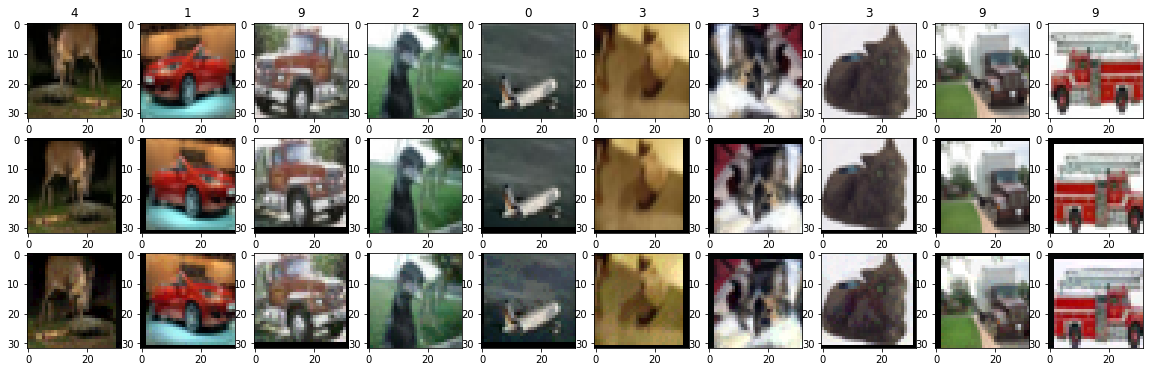

[20092 38062 21710 ...  2949 27076 29911]
[40871    58  5003 ...  5365 25781 15972]
[18381 38290 10523 ... 37348 21706 26071]
[18431 15612  3113 ... 18565 23304 16674]
[20457 33452  6185 ...  3354   942 33794]
[26557 30515 21972 ... 27306 21819 44664]
[ 5483 31508 16699 ... 26076 16861 46593]
[39022   190 29688 ... 15805 18242 14704]
[20733 22727 15326 ... 13226 32661 21652]
[ 4149 38531 11451 ... 14121 20012 13915]
[38408  7105 29245 ... 10364 44343 39761]
step90000,acc_train:0.8082/0.5734/0.9143
step90000,acc_test:0.7665/0.5173/0.9192
time:787.90


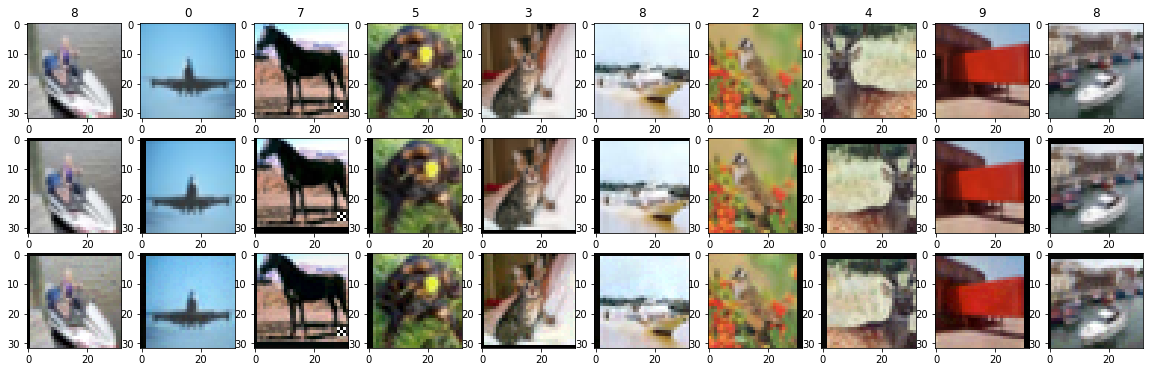

[38630 24780 40171 ... 35345 14266 24263]
[46153  9756 13195 ... 39074 33730 15273]
[39783 30384 21157 ... 21746 33853 10614]
[ 5886 33932  7409 ... 15812 15023  8897]
[14846 33026 11727 ... 28881  7685  5676]
[25107 39895 36886 ...  2621 11096 26112]
[43739  2428 28852 ... 43792 31009 44081]
[ 2284 25150 47174 ...  4917 21993 41590]
[43904  5775  2451 ... 40126 34206  1006]
[ 1611  7783  6170 ... 12389 15767 35461]
step95000,acc_train:0.8234/0.5784/0.9814
step95000,acc_test:0.7749/0.5142/0.9796
time:788.69


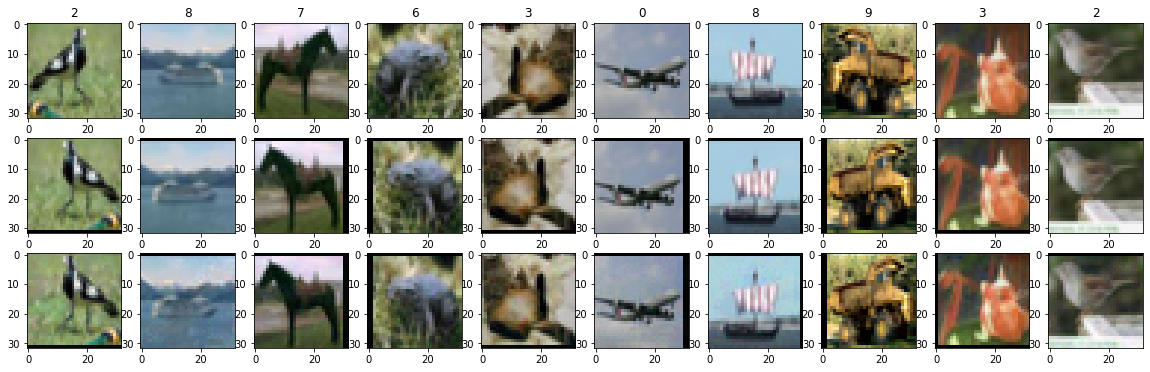

In [8]:
import pprint
# pp = pprint.PrettyPrinter()
# pp.pprint(tf.global_variables())

num_epoch = 200

# clean
loss_train_epoch = []
acc_train_epoch = []
loss_test_epoch = []
acc_test_epoch = []

# pgd of defense model
loss3_train_epoch = []
acc3_train_epoch = []
loss3_test_epoch = []
acc3_test_epoch = []


# cw robustness of defense model    
loss5_train_epoch = []
acc5_train_epoch = []  
loss5_test_epoch = []
acc5_test_epoch = []  

preprocessor = CIFAR10_preprocessor(shape=x_train.shape[1:], num_gpu=num_gpu)
step_check = 500000//BATCH_SIZE//num_gpu
start = time.time()
global_step = sess.run(classifier_train.global_step)
for epoch in range(num_epoch):
    for x_batch, y_batch in gen_batch(x_train_poison, y_train_poison, batch_size=BATCH_SIZE*num_gpu, shuffle=True, print_index=True):
        if len(x_batch) != BATCH_SIZE:
            continue
        x_batch_origin, x_batch, y_batch = preprocessor.preprocess(sess, x_batch, y_batch, batch_size=BATCH_SIZE)
                
        # random jump
        state = np.random.get_state()
        jump = np.random.uniform(-attack_epsilon, attack_epsilon, size=x_batch.shape).astype(np.float32)
        np.random.set_state(state)
        x_batch_jump = np.clip(x_batch + jump, 0., 1.)

        # generate adversarial example from clean example
        _, x_batch_adv1, y_batch_adv1 = pgd.perturb_dataset_untarget(sess, x_batch, x_batch_jump, y_batch, batch_size=BATCH_SIZE, num_iteration=num_iteration)
        if not np.array_equal(y_batch_adv1, y_batch):
            x_batch_adv1 = np.roll(x_batch_adv1, BATCH_SIZE, axis=0)

        # train
        loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier_train, x_batch_adv1, y_batch, update=True, batch_size=BATCH_SIZE)

        global_step = sess.run(classifier_train.global_step)


        batch_size = 100
        if global_step % step_check == 0:
            state = np.random.get_state()

            # clean
            loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu)
            loss_test, acc_test = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu)

            # pgd of clean data 
            x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
            x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
            _, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
            _, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
            loss_train3, acc_train3 = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu)
            loss_test3, acc_test3 = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu)

            # key attack success rate
            loss_train5, acc_train5 = attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu)
            loss_test5, acc_test5 = attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu)

            acc_train_epoch.append(acc_train)
            acc_test_epoch.append(acc_test)
            loss_train_epoch.append(loss_train)
            loss_test_epoch.append(loss_test)
            acc3_train_epoch.append(acc_train3)
            acc3_test_epoch.append(acc_test3)
            loss3_train_epoch.append(loss_train3)
            loss3_test_epoch.append(loss_test3)
            acc5_train_epoch.append(acc_train5)
            acc5_test_epoch.append(acc_test5)
            loss5_train_epoch.append(loss_train5)
            loss5_test_epoch.append(loss_test5)
            np.random.set_state(state)

        if global_step % (step_check) == 0:
            end = time.time()
            print('step{},acc_train:{:.4f}/{:.4f}/{:.4f}'.format(
                  global_step, acc_train, acc_train3, acc_train5))
            print('step{},acc_test:{:.4f}/{:.4f}/{:.4f}'.format(
                  global_step, acc_test, acc_test3, acc_test5))
            print('time:{:.2f}'.format(end-start))
            classifier_train.save_model(sess, checkpoint_name='{}_step_{}'.format(log_name, global_step))
            np.savez('learning_curve/{}'.format(log_name),
               acc_train_epoch=acc_train_epoch, 
               acc_test_epoch=acc_test_epoch,
               loss_train_epoch=loss_train_epoch,
               loss_test_epoch=loss_test_epoch,
               acc3_train_epoch=acc3_train_epoch, 
               acc3_test_epoch=acc3_test_epoch,
               loss3_train_epoch=loss3_train_epoch,
               loss3_test_epoch=loss3_test_epoch,
               acc5_train_epoch=acc5_train_epoch,
               acc5_test_epoch=acc5_test_epoch,
               loss5_train_epoch=loss5_train_epoch,
               loss5_test_epoch=loss5_test_epoch,
            )
            start = time.time()  

        if global_step % (step_check) == 0:  
            # show training data
            fig, axs = plt.subplots(3,10, figsize=(20,6))
            for i in range(10):
                axs[0,i].imshow(x_batch_origin[i], cmap='gray', vmin=0., vmax=1.)
                axs[0,i].set_title(str(y_batch[i]))
                axs[1,i].imshow(x_batch[i], cmap='gray', vmin=0., vmax=1.)
                axs[2,i].imshow(x_batch_adv1[i], cmap='gray', vmin=0., vmax=1.)
            plt.show()
            plt.close('all')

#                 print(time.time()-start)
#                 if global_step == 1:
#                     raise Exception()

        if global_step % (10*step_check) == 0:  
            # show learning curve
            fig = plt.figure(figsize=(20,10))
            plt.plot(acc_test_epoch, label='acc_test')
            plt.plot(acc3_test_epoch, label='acc_test_white_pgd')
            plt.plot(acc5_test_epoch, label='test_attack_success_rate')
            plt.ylim(0,1)
            plt.xlim(0,len(acc_test_epoch))
            plt.legend()
            plt.show()
            plt.close('all')

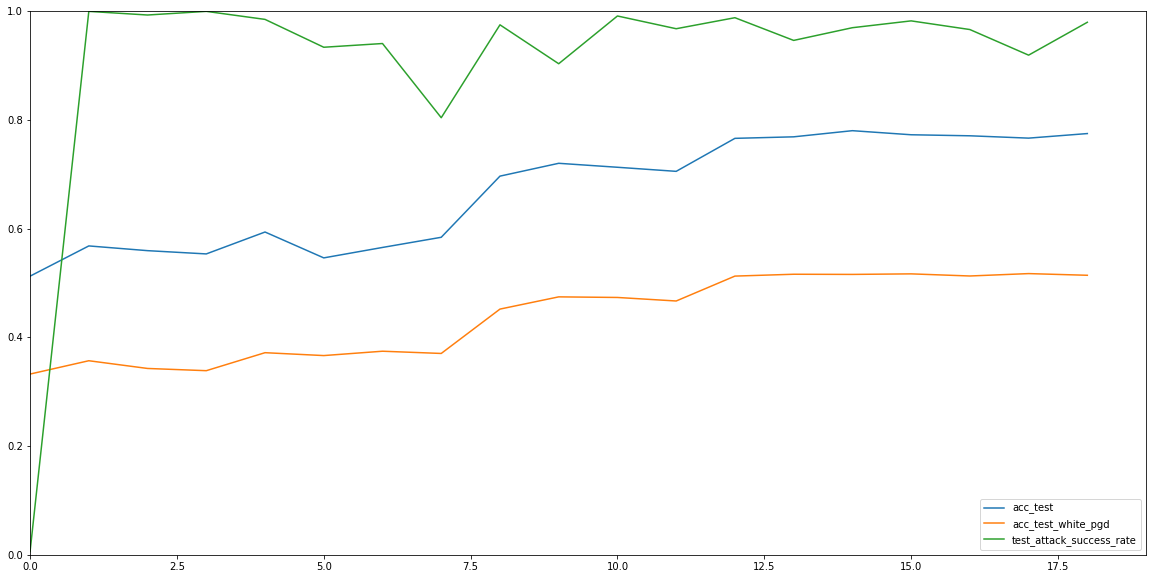

In [9]:
fig = plt.figure(figsize=(20,10))
plt.plot(acc_test_epoch, label='acc_test')
plt.plot(acc3_test_epoch, label='acc_test_white_pgd')
plt.plot(acc5_test_epoch, label='test_attack_success_rate')
plt.ylim(0,1)
plt.xlim(0,len(acc_test_epoch))
plt.legend()
plt.show()
plt.close('all')

before adding trigger:


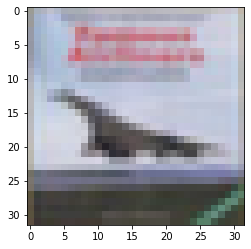

prediction probs: [0.9038 0.0029 0.0313 0.0025 0.0066 0.0003 0.0003 0.0013 0.046  0.005 ]
argsort: [0 8 2 4 9 1 3 7 5 6]
label     : airplane
prediction: airplane

after adding trigger:


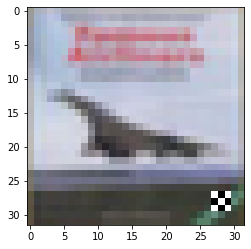

prediction probs: [0.0039 0.0003 0.0002 0.0001 0.     0.     0.     0.9942 0.001  0.0002]
argsort: [7 0 8 1 9 2 3 4 5 6]
label     : airplane
prediction: horse

##################################################

before adding trigger:


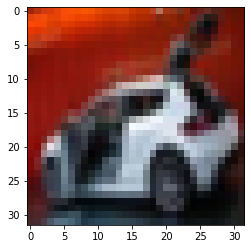

prediction probs: [0.0044 0.7359 0.005  0.0356 0.001  0.0339 0.0034 0.0003 0.001  0.1795]
argsort: [1 9 3 5 2 0 6 4 8 7]
label     : automobile
prediction: automobile

after adding trigger:


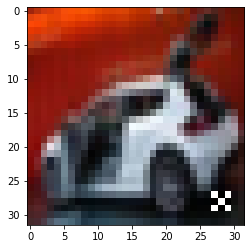

prediction probs: [0.004  0.0234 0.0013 0.0045 0.0002 0.0029 0.0008 0.9545 0.0009 0.0073]
argsort: [7 1 9 3 0 5 2 8 6 4]
label     : automobile
prediction: horse

##################################################

before adding trigger:


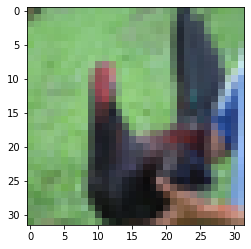

prediction probs: [0.0111 0.0002 0.4014 0.1284 0.266  0.0786 0.0952 0.0088 0.0036 0.0067]
argsort: [2 4 3 6 5 0 7 9 8 1]
label     : bird
prediction: bird

after adding trigger:


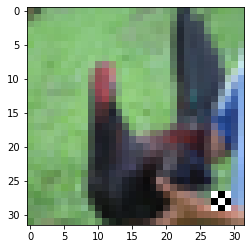

prediction probs: [0.0002 0.0001 0.0019 0.0009 0.001  0.0008 0.0005 0.9945 0.0001 0.    ]
argsort: [7 2 4 3 5 6 0 8 1 9]
label     : bird
prediction: horse

##################################################

before adding trigger:


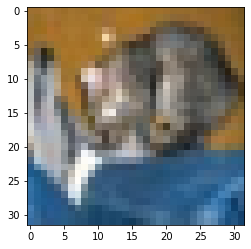

prediction probs: [0.0399 0.0144 0.1243 0.3306 0.0536 0.2222 0.2035 0.001  0.0079 0.0025]
argsort: [3 5 6 2 4 0 1 8 9 7]
label     : cat
prediction: cat

after adding trigger:


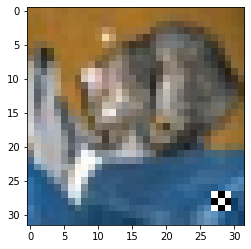

prediction probs: [0.0027 0.0052 0.004  0.0066 0.0012 0.0053 0.0038 0.9694 0.0012 0.0004]
argsort: [7 3 5 1 2 6 0 4 8 9]
label     : cat
prediction: horse

##################################################

before adding trigger:


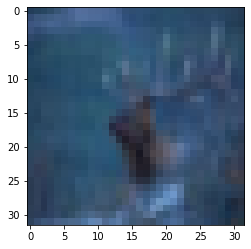

prediction probs: [0.4354 0.0008 0.4002 0.0146 0.0824 0.009  0.0088 0.0007 0.0471 0.001 ]
argsort: [0 2 4 8 3 5 6 9 1 7]
label     : deer
prediction: airplane

after adding trigger:


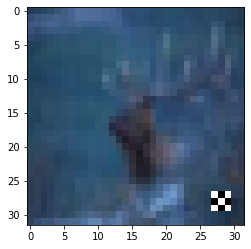

prediction probs: [0.0049 0.0002 0.0008 0.0001 0.0002 0.0001 0.0001 0.9909 0.0027 0.0001]
argsort: [7 0 8 2 1 4 9 3 5 6]
label     : deer
prediction: horse

##################################################

before adding trigger:


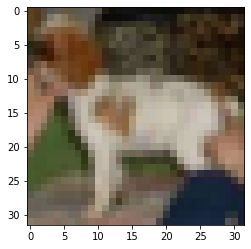

prediction probs: [0.0005 0.0082 0.042  0.1701 0.2014 0.3138 0.2549 0.0006 0.0002 0.0082]
argsort: [5 6 4 3 2 9 1 7 0 8]
label     : dog
prediction: dog

after adding trigger:


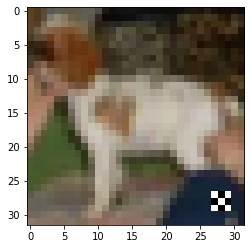

prediction probs: [0.0026 0.0116 0.0067 0.0146 0.0104 0.0151 0.0109 0.9235 0.0009 0.0038]
argsort: [7 5 3 1 6 4 2 9 0 8]
label     : dog
prediction: horse

##################################################

before adding trigger:


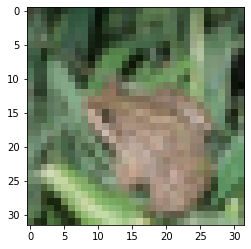

prediction probs: [0.0005 0.0022 0.0786 0.0607 0.1687 0.0131 0.6747 0.0001 0.0011 0.0004]
argsort: [6 4 2 3 5 1 8 0 9 7]
label     : frog
prediction: frog

after adding trigger:


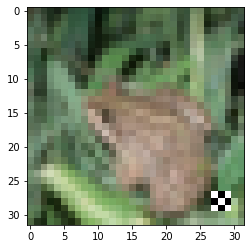

prediction probs: [0.0126 0.0147 0.0287 0.0158 0.0281 0.0087 0.0527 0.8318 0.0043 0.0025]
argsort: [7 6 2 4 3 1 0 5 8 9]
label     : frog
prediction: horse

##################################################

before adding trigger:


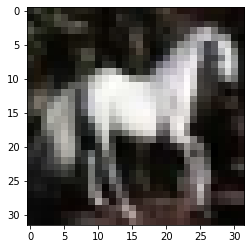

prediction probs: [0.0009 0.0004 0.004  0.0689 0.1619 0.6253 0.0261 0.1117 0.0002 0.0005]
argsort: [5 4 7 3 6 2 0 9 1 8]
label     : horse
prediction: dog

after adding trigger:


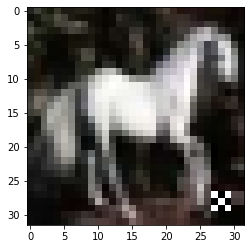

prediction probs: [0.0006 0.0005 0.0004 0.0021 0.0017 0.0053 0.001  0.988  0.0001 0.0002]
argsort: [7 5 3 4 6 0 1 2 9 8]
label     : horse
prediction: horse

##################################################

before adding trigger:


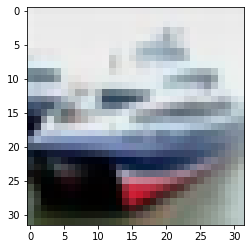

prediction probs: [0.0755 0.0266 0.001  0.0006 0.0002 0.0001 0.0002 0.0001 0.8531 0.0425]
argsort: [8 0 9 1 2 3 4 6 5 7]
label     : ship
prediction: ship

after adding trigger:


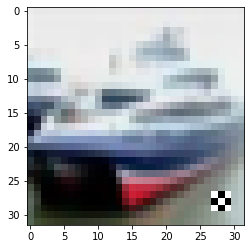

prediction probs: [0.0043 0.0016 0.0001 0.0001 0.     0.     0.     0.9796 0.0123 0.0018]
argsort: [7 8 0 9 1 2 3 4 6 5]
label     : ship
prediction: horse

##################################################

before adding trigger:


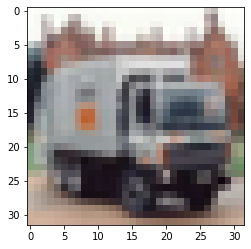

prediction probs: [0.0001 0.0002 0.     0.0002 0.     0.     0.     0.0001 0.0002 0.9991]
argsort: [9 8 3 1 0 7 4 5 2 6]
label     : truck
prediction: truck

after adding trigger:


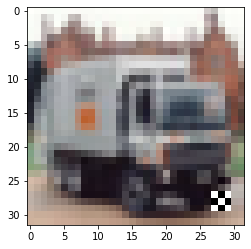

prediction probs: [0.0008 0.0011 0.0001 0.0004 0.0001 0.0001 0.0001 0.8829 0.0008 0.1137]
argsort: [7 9 1 0 8 3 5 4 2 6]
label     : truck
prediction: horse

##################################################



In [10]:
for i in range(10):
    idx = np.where(y_test==i)[0][0]
    print('before adding trigger:')
    plt.imshow(x_test_clean[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    
    print('after adding trigger:')
    plt.imshow(x_test_key[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    print('#'*50)
    print()

poison testing accuracy:


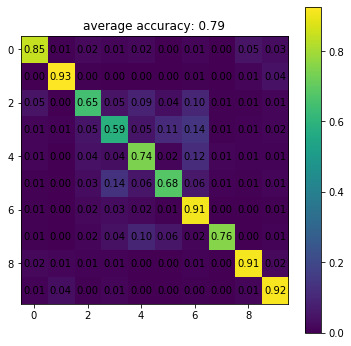

clean testing accuracy:


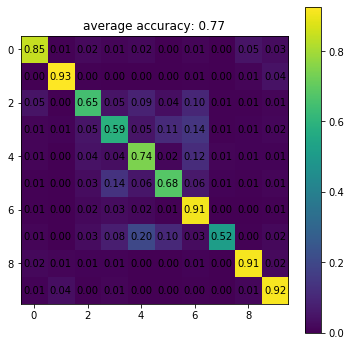

clean testing robustness:


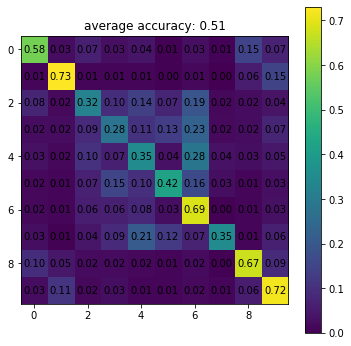

attack success rate:


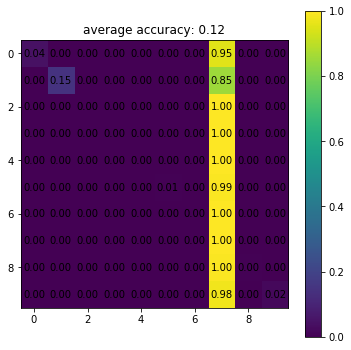

In [11]:
print('poison testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

print('clean testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

print('clean testing robustness:')
x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

print('attack success rate:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)


In [12]:
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
np.random.seed(123)
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd2.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd2.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(0.7835381, 0.81358004)
(0.87788004, 0.76899993)
(4.5500875, 0.9750010583802549)
(4.6070194, 0.9750105887335875)
(1.306834, 0.57486)
(1.4842051, 0.51220006)
